In [226]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import pickle

In [227]:
# LOAD DATASET
df = pd.read_csv("/content/telco_customer_churn.csv")

In [228]:
# INITIAL INSPECTION
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nUnique values per column:\n", df.nunique())

Shape of dataset: (7043, 21)

Data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contrac


Categorical Columns:
 ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

Missing values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


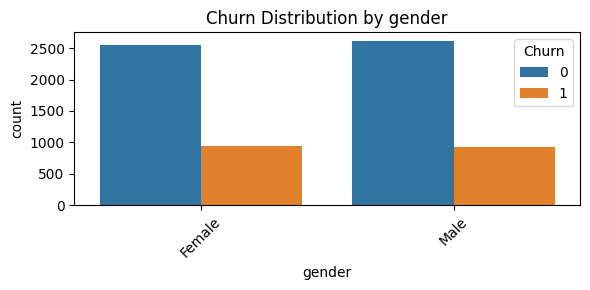

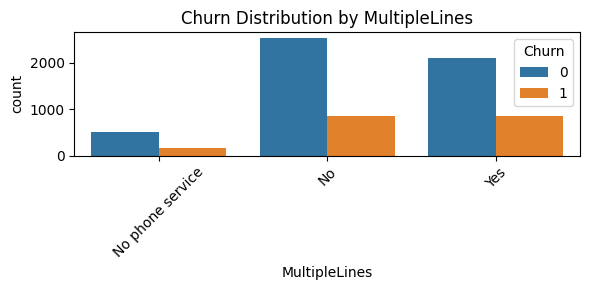

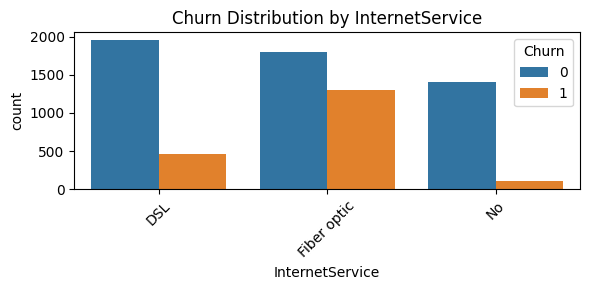

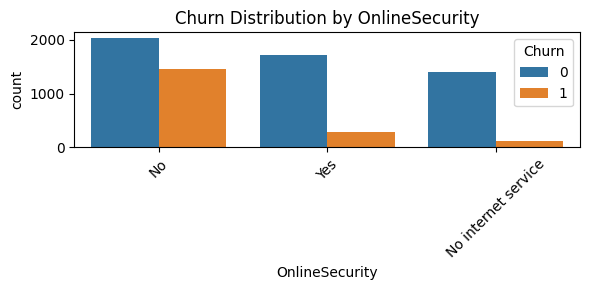

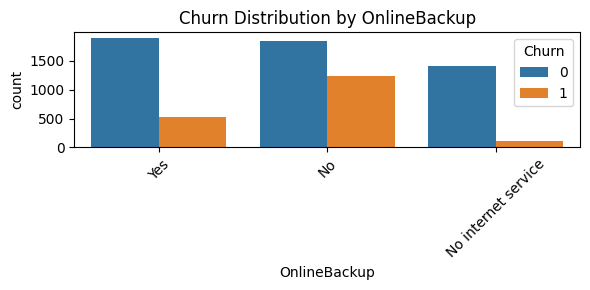

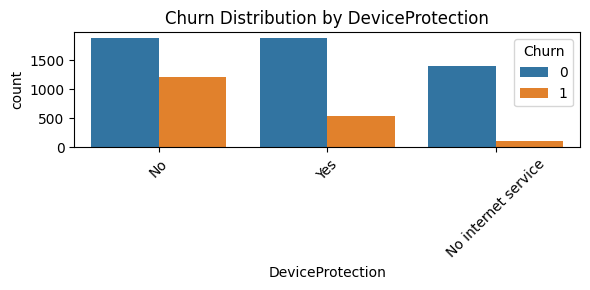

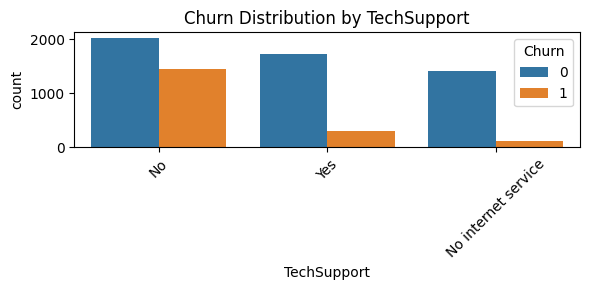

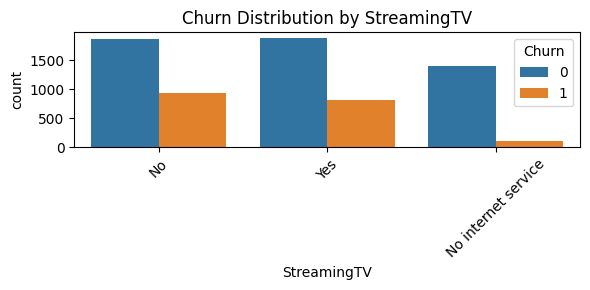

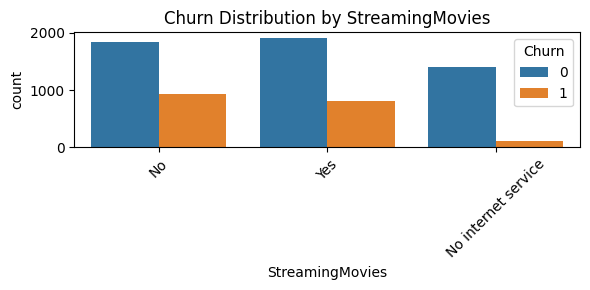

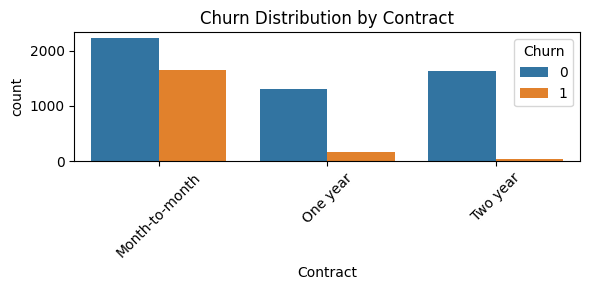

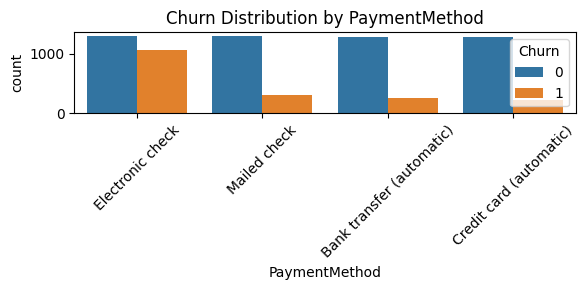


Numerical Columns:
 ['tenure', 'MonthlyCharges', 'TotalCharges']


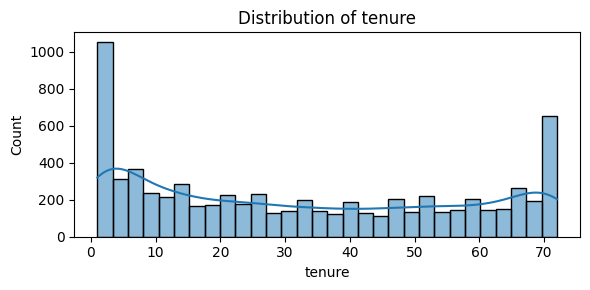

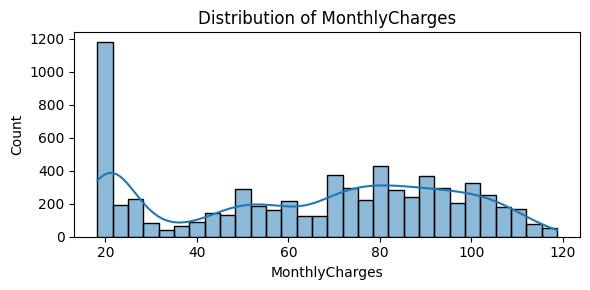

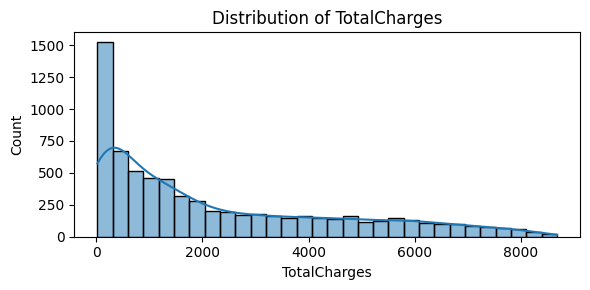

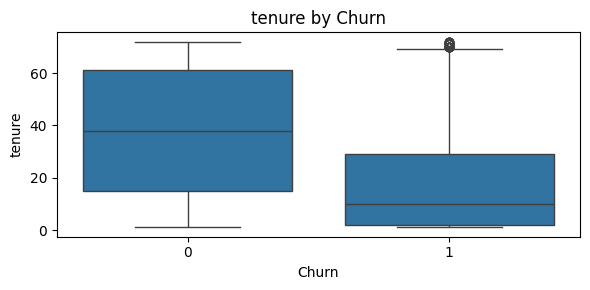

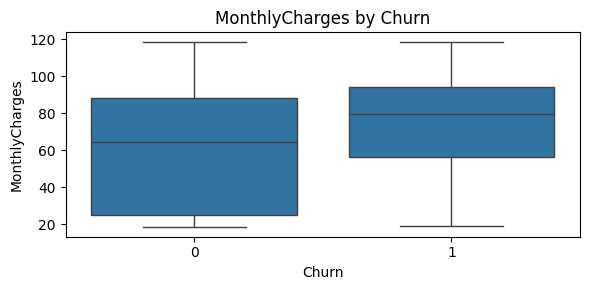

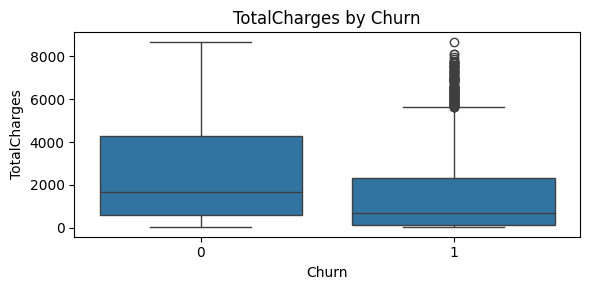

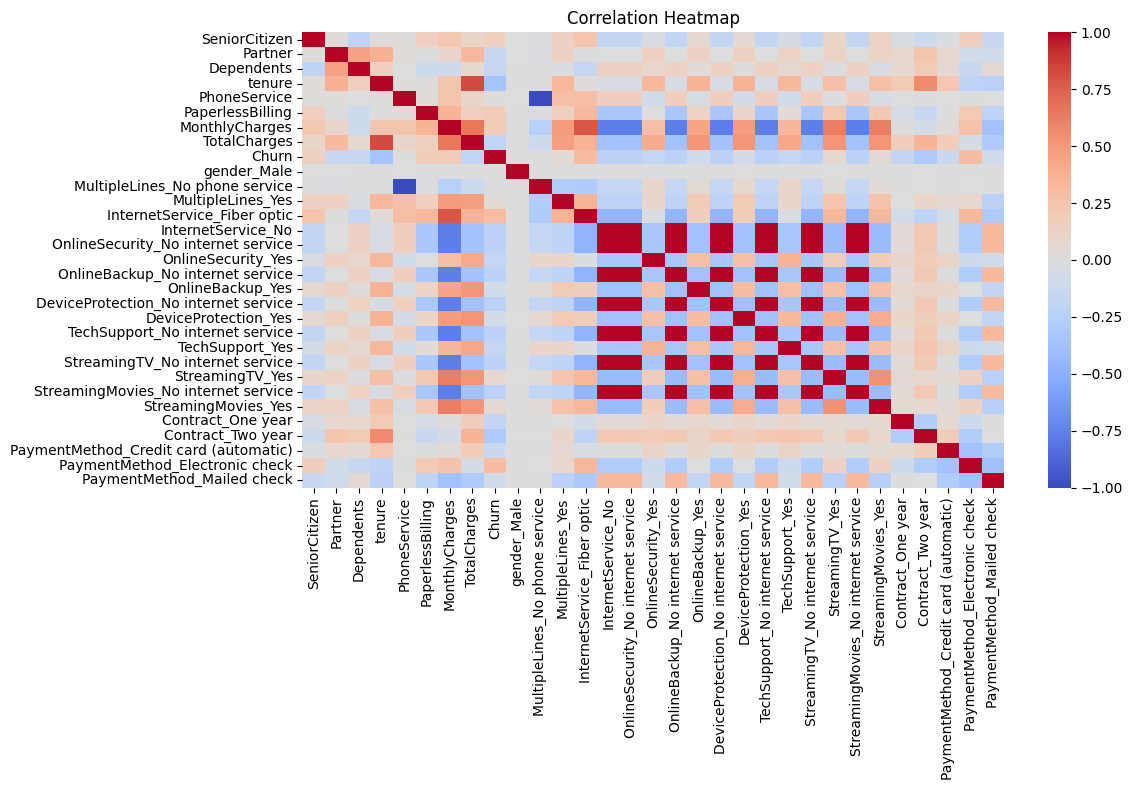


Churn Rate:
 Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


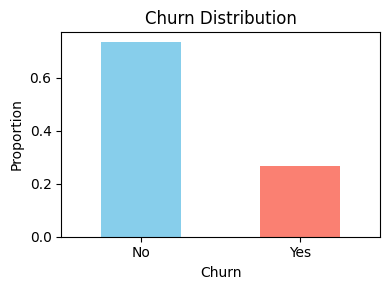


Missing values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [229]:
# DATA CLEANING

# Remove customerID (not useful for modeling)
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric (handle strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Remove rows where TotalCharges is missing
df.dropna(subset=['TotalCharges'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# ENCODE BINARY CATEGORICALS (Yes/No -> 1/0)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# UNIVARIATE ANALYSIS (CATEGORICAL FEATURES)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns:\n", categorical_cols)

print("\nMissing values:\n", df.isnull().sum())
for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn Distribution by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# UNIVARIATE ANALYSIS (NUMERICAL FEATURES)
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("\nNumerical Columns:\n", numerical_cols)

for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# BIVARIATE ANALYSIS (NUMERICAL vs CHURN)
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.tight_layout()
    plt.show()

# CORRELATION MATRIX
# Convert all object types to category dummies for correlation heatmap
df_encoded = pd.get_dummies(df, drop_first=True)

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# CHURN RATE
churn_rate = df['Churn'].value_counts(normalize=True)
print("\nChurn Rate:\n", churn_rate)

plt.figure(figsize=(4, 3))
churn_rate.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

print("\nMissing values:\n", df.isnull().sum())

In [230]:
# LOG TRANSFORMATION TO REDUCE SKEW
df['LogTotalCharges'] = np.log1p(df['TotalCharges'])

# DROP UNUSED / REDUNDANT FEATURES
df.drop(['TotalCharges'], axis=1, inplace=True)

# REPLACE 'No internet service' AND 'No phone service' WITH 'No'
no_service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in no_service_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# BINARY ENCODING FOR YES/NO COLUMNS
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[binary_cols] = df[binary_cols].replace({'Yes': 1, 'No': 0})

# ONE-HOT ENCODE CATEGORICAL FEATURES
df = pd.get_dummies(df, drop_first=True)

# DEFINE X, y AND TRAIN-TEST SPLIT
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# HANDLE IMBALANCE WITH SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# STANDARDIZE NUMERICAL COLUMNS
scaler = StandardScaler()

# Fit only on training set
X_train_sm_scaled = X_train_sm.copy()
X_test_scaled = X_test.copy()

# Select numeric columns to scale
num_cols = ['tenure', 'MonthlyCharges', 'LogTotalCharges']
X_train_sm_scaled[num_cols] = scaler.fit_transform(X_train_sm[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

df.to_csv('preprocessed.csv')

In [231]:
# TRAIN ALL THREE MODELS

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_sm_scaled, y_train_sm)

# Random Forest
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train_sm_scaled, y_train_sm)

# XGBoost
scale_pos_weight = (y_train_sm == 0).sum() / (y_train_sm == 1).sum()
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=scale_pos_weight, random_state=42)
xgb_clf.fit(X_train_sm_scaled, y_train_sm)

results = []
# DEFINE EVALUATION FUNCTION
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

# EVALUATE ALL MODELS
evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression")
evaluate_model(rf_clf, X_test_scaled, y_test, "Random Forest")
evaluate_model(xgb_clf, X_test_scaled, y_test, "XGBoost")

# CREATE COMPARISON TABLE
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)
print("\n Model Performance Comparison:\n")
print(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:14:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Model Performance Comparison:

                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression  0.751244   0.525105  0.671123  0.589202  0.809455
1        Random Forest  0.771144   0.567358  0.585561  0.576316  0.805371
2              XGBoost  0.751955   0.529274  0.604278  0.564295  0.798110


In [232]:
# Get feature importance from trained XGBoost model
xgb_importance = xgb_clf.feature_importances_  # assuming xgb_model is already fitted
features = X_train.columns

# Create DataFrame and sort
xgb_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)

# Select top 10 features
top_xgb_features = xgb_importance_df['Feature'].head(10).tolist()

# Subset training and testing data
X_train_xgb_top = X_train[top_xgb_features]
X_test_xgb_top = X_test[top_xgb_features]

# Train new XGBoost model on reduced features
xgb_top = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_top.fit(X_train_xgb_top, y_train)

# Predict and evaluate
y_pred_xgb_top = xgb_top.predict(X_test_xgb_top)
y_proba_xgb_top = xgb_top.predict_proba(X_test_xgb_top)[:, 1]

# Print results
print("XGBoost with Top 10 Features")
print("New Accuracy:", accuracy_score(y_test, y_pred_xgb_top))
print("New AUC:", roc_auc_score(y_test, y_proba_xgb_top))

XGBoost with Top 10 Features
New Accuracy: 0.7711442786069652
New AUC: 0.8094499174306702


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:14:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [233]:
# Tune XGBoost Classifier
# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]  # from earlier
}

xgb_grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_xgb_top, y_train)

# Evaluate Tuned Model on Test Set
# Predict on test set
xgb_best = xgb_grid.best_estimator_

xgb_proba = xgb_best.predict_proba(X_test_xgb_top)[:, 1]

# Evaluate and add
evaluate_model(xgb_best, X_test_xgb_top, y_test, "XGBoost (Tuned)")

# Final Comparison Table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)

print("\n Final Model Performance Comparison:")
print(results_df)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Final Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0      XGBoost (Tuned)  0.793888   0.640000  0.513369  0.569733  0.834696
1  Logistic Regression  0.751244   0.525105  0.671123  0.589202  0.809455
2        Random Forest  0.771144   0.567358  0.585561  0.576316  0.805371
3              XGBoost  0.751955   0.529274  0.604278  0.564295  0.798110


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:14:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [234]:
# Ensemble Model: VotingClassifier
# Define base models (retrained on same data)
log_reg_v = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf_v = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb_v = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                      scale_pos_weight=scale_pos_weight, random_state=42)

# Combine into soft voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg_v),
        ('rf', rf_v),
        ('xgb', xgb_v)
    ],
    voting='soft'
)

# Fit on training data
voting_clf.fit(X_train_sm_scaled, y_train_sm)

# Evaluate
evaluate_model(voting_clf, X_test_scaled, y_test, "Voting Classifier (Soft)")

# Updated Results Table
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False).reset_index(drop=True)
print("\nUpdated Model Comparison with Voting:")
print(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:14:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Updated Model Comparison with Voting:
                      Model  Accuracy  Precision    Recall  F1-Score       AUC
0           XGBoost (Tuned)  0.793888   0.640000  0.513369  0.569733  0.834696
1  Voting Classifier (Soft)  0.765458   0.551887  0.625668  0.586466  0.814580
2       Logistic Regression  0.751244   0.525105  0.671123  0.589202  0.809455
3             Random Forest  0.771144   0.567358  0.585561  0.576316  0.805371
4                   XGBoost  0.751955   0.529274  0.604278  0.564295  0.798110


In [235]:
# Ensemble Model: StackingClassifier
# Define base learners
estimators = [
    ('log_reg', log_reg_v),
    ('rf', rf_v),
    ('xgb', xgb_v)
]

# Meta learner
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=True  # Let meta-learner also see original features
)

# Fit and evaluate
stacking_clf.fit(X_train_sm_scaled, y_train_sm)
evaluate_model(stacking_clf, X_test_scaled, y_test, "Stacking Classifier")

# Updated Results Table
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False).reset_index(drop=True)
print("\nUpdated Model Comparison with Stacking:")
print(results_df)


Updated Model Comparison with Stacking:
                      Model  Accuracy  Precision    Recall  F1-Score       AUC
0           XGBoost (Tuned)  0.793888   0.640000  0.513369  0.569733  0.834696
1  Voting Classifier (Soft)  0.765458   0.551887  0.625668  0.586466  0.814580
2       Logistic Regression  0.751244   0.525105  0.671123  0.589202  0.809455
3             Random Forest  0.771144   0.567358  0.585561  0.576316  0.805371
4       Stacking Classifier  0.765458   0.560440  0.545455  0.552846  0.804876
5                   XGBoost  0.751955   0.529274  0.604278  0.564295  0.798110


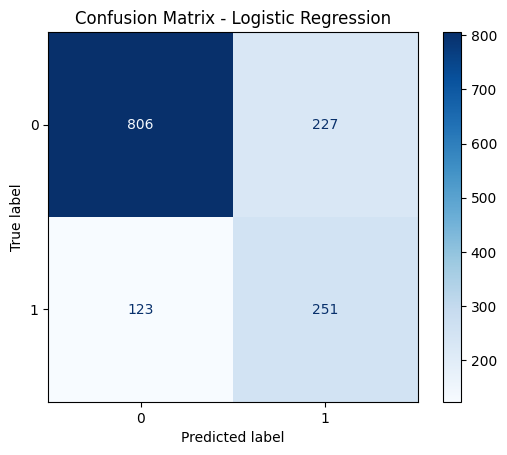

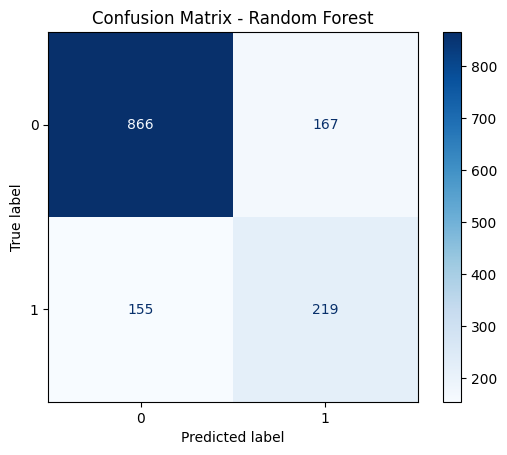

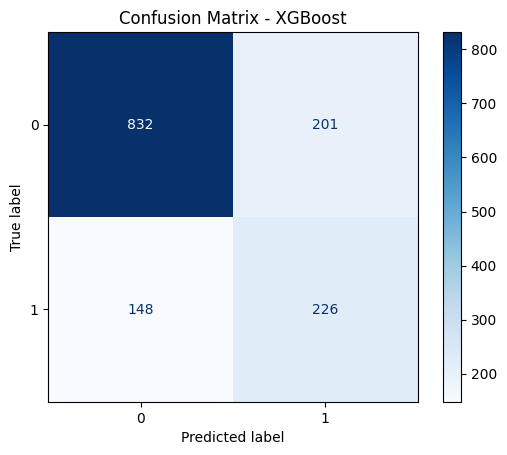

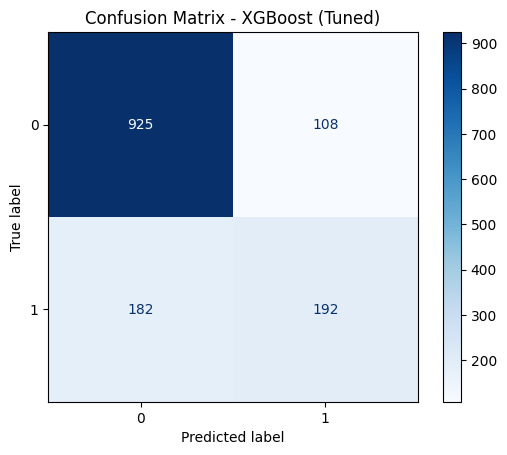

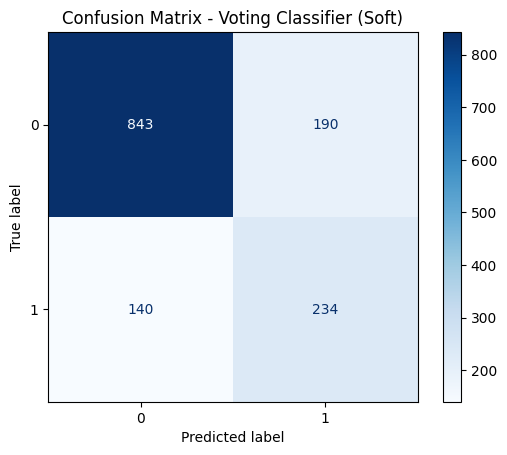

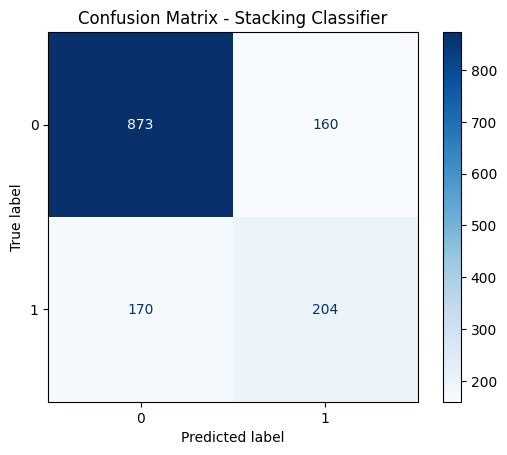

In [236]:
# Plot Confusion Matrices for all models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf,
    "XGBoost (Tuned)": xgb_best,
    "Voting Classifier (Soft)": voting_clf,
    "Stacking Classifier": stacking_clf
}

for name, model in models.items():
    if name == "XGBoost (Tuned)":
        y_pred = model.predict(X_test_xgb_top)
    else:
        y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

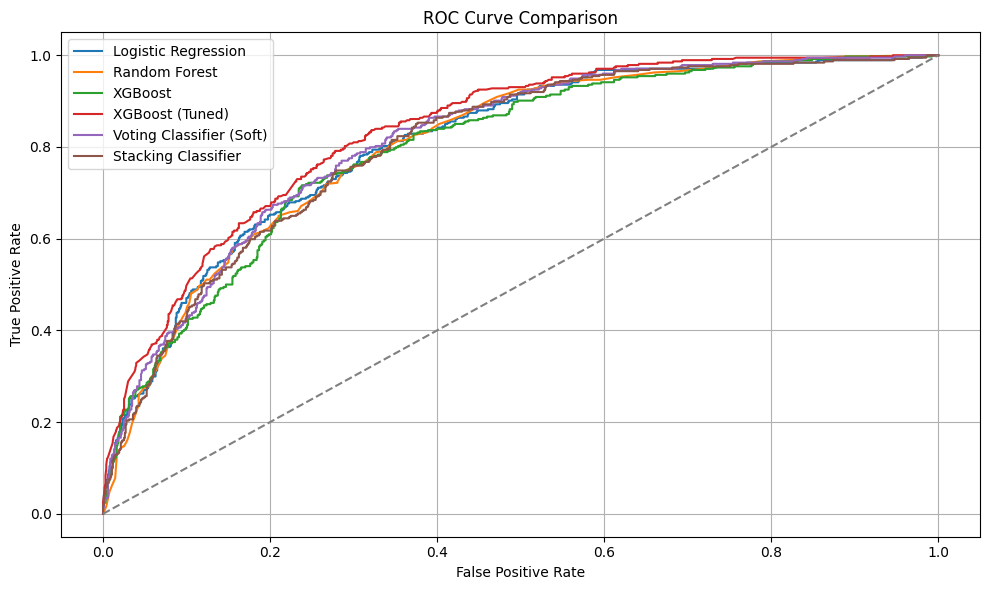

In [237]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    if name == "XGBoost (Tuned)":
        X_test_input = X_test_xgb_top
    else:
        X_test_input = X_test_scaled
    y_proba = model.predict_proba(X_test_input)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name}")

# Random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [239]:
# Save tuned XGBoost model
with open("xgboost_tuned_model.pkl", "wb") as f:
    pickle.dump(xgb_best, f)

print("Tuned XGBoost model saved as 'xgboost_tuned_model.pkl'")
print(top_xgb_features)

Tuned XGBoost model saved as 'xgboost_tuned_model.pkl'
['PaymentMethod_Electronic check', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Two year', 'Dependents', 'Contract_One year', 'PhoneService', 'PaymentMethod_Credit card (automatic)', 'tenure', 'MultipleLines_Yes']
